<a href="https://colab.research.google.com/github/MSHQD/HWR/blob/main/Instance_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import cv2
import albumentations as A
import random
import json
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
import torch, torchvision
import warnings
import sys
from skimage import io
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore")
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import shutil
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch.optim as optim
import torchvision
import collections
from torchvision import datasets, models, transforms

# import paddle

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# !python ppdet/modeling/tests/test_architectures.py

In [4]:
import torch
from torch import nn

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [5]:
4# data_dir = '/content/drive/MyDrive/НТИ ИИ /data_team/'
project_dir = '/content/drive/MyDrive'
# data_dir = 'data'
train_images = 'train_recognition_small/images'
image_size = 256
first_size = 512

# Settings

In [6]:
# !unzip -q '/content/drive/MyDrive/НТИ ИИ /data_team/data_final.zip'

import zipfile
zip1 = '/content/drive/MyDrive/train_recognition_small.zip'
extract_to1 = '/content/train_recognition_small'

with zipfile.ZipFile(zip1, 'r') as zip_ref:
    zip_ref.extractall(extract_to1)

zip2 = '/content/drive/MyDrive/train_segmentation_small.zip'
extract_to2 = '/content/train_segmentation_small'
with zipfile.ZipFile(zip2, 'r') as zip_ref:
    zip_ref.extractall(extract_to2)

In [31]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

sed -i \
  -e '/import torch._six/d' \
  -e 's/torch\.\_six\.string_classes/str/g' \
  -e '$a\
COCO.loadRes = loadRes' \
  ../coco_eval.py

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be376084d8 version check against PyTorch's CUDA version


# Building datasets

### Load annotations

In [32]:
annotation = pd.read_csv('train_recognition_small/train_recognition_small/labels_small.csv')

In [33]:
import json

with open('train_segmentation_small/train_segmentation_small/annotations.json') as f:
    seg_annotations = json.load(f)

In [34]:
from sklearn.model_selection import train_test_split

# val_annot = seg_annotations.copy()
# train_annot = seg_annotations.copy()

# train_annot['images'], val_annot['images']  = train_test_split(seg_annotations['images'], test_size=0.1, random_state=42)

existing_images = [
    img for img in seg_annotations['images']
    if os.path.exists(os.path.join('train_segmentation_small/train_segmentation_small/images', img['file_name']))
]

train_imgs, val_imgs = train_test_split(existing_images, test_size=0.2, random_state=42)

train_ids = {img['id'] for img in train_imgs}
val_ids = {img['id'] for img in val_imgs}

train_annot = {
    "images": train_imgs,
    "annotations": [ann for ann in seg_annotations['annotations'] if ann['image_id'] in train_ids],
    "categories": seg_annotations['categories']
}
val_annot = {
    "images": val_imgs,
    "annotations": [ann for ann in seg_annotations['annotations'] if ann['image_id'] in val_ids],
    "categories": seg_annotations['categories']
}

In [35]:
with open(os.path.join('train_segmentation_small/train_segmentation_small/annotations_val.json'), 'w') as outfile:
    json.dump(val_annot, outfile)


with open(os.path.join('train_segmentation_small/train_segmentation_small/annotations_train.json'), 'w') as outfile:
    json.dump(train_annot, outfile)

In [36]:
collections.Counter([(el['height'], el['width']) for el in seg_annotations['images']]).most_common()

[((3024, 4032), 398),
 ((3000, 4000), 219),
 ((4032, 3024), 173),
 ((1960, 4032), 74),
 ((4000, 3000), 35),
 ((3999, 2999), 29),
 ((3900, 3000), 1),
 ((3797, 2959), 1),
 ((3815, 2999), 1),
 ((3815, 2930), 1)]

### define dataset

In [37]:
def numbers2coords(list_of_numbers):
    """Convert list of numbers to list of tuple coords x, y."""
    bbox = [
        [list_of_numbers[i], list_of_numbers[i + 1]]
        for i in range(0, len(list_of_numbers), 2)
    ]
    return np.array(bbox)

In [38]:
def get_data_from_image(data, image_id):
    texts = []
    polygons = []
    for idx, data_ann in enumerate(data["annotations"]):
        if (
            data_ann["image_id"] == image_id
            and data_ann["attributes"]
            and data_ann["attributes"]["translation"]
            and data_ann["segmentation"]
        ):
            polygon = numbers2coords(data_ann["segmentation"][0])
            polygons.append(polygon)
            texts.append(data_ann["attributes"]["translation"])
    return texts, polygons

In [39]:
from shapely.geometry import Polygon
from albumentations.pytorch.transforms import ToTensorV2
import albumentations as A


class SegDataset(Dataset):
    def __init__(self, img_folder, data, transforms):
        self.img_folder = img_folder
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data['images'])

    # def _load_file(self, path):
    #     image = cv2.imread(path)
    #     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #     return image

    def _load_file(self, path):
      image = cv2.imread(path)
      if image is None:
          raise FileNotFoundError(f"Не удалось загрузить изображение: {path}")
      return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    def __getitem__(self, idx):
        data_img = self.data['images'][idx]
        img_name = data_img["file_name"]
        image_id = data_img["id"]
        image = self._load_file(os.path.join(self.img_folder, img_name))

        texts_from_image, polygons_from_image = get_data_from_image(self.data, image_id)

        masks = []
        mask = np.zeros_like(image)
        used = [(0, 0, 0)]
        for i, polygon in enumerate(polygons_from_image):
          polygon = np.array([[int(el[0]), int(el[1])] for el in polygon])
          color = (0, 0, 0)
          while color in used:
            color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
          used.append(color)
          cv2.drawContours(mask, [polygon], -1, color=color, thickness=cv2.FILLED)

        transformed = self.transforms(image=image, mask=mask)
        image = transformed['image']
        mask = (transformed['mask'].squeeze() * 255).astype(np.uint8)
        plt.imshow(mask)
        plt.show()
        print(image.shape, mask.shape)

        obj_ids = np.unique(mask.reshape(-1, 3), axis=0)
        obj_ids = np.array([el for el in obj_ids if (el != np.array([0, 0, 0])).any()])
        num_objs = len(obj_ids)

        masks = []
        boxes = []
        area = []
        for i in range(num_objs):
          now = (mask == obj_ids[i]).all(axis=-1)
          pos = np.where(now)

          xmin = np.min(pos[1])
          xmax = np.max(pos[1])
          ymin = np.min(pos[0])
          ymax = np.max(pos[0])

          if xmax - xmin > 0 and ymax - ymin > 0:
            boxes.append([xmin, ymin, xmax, ymax])
            masks.append(now)
            area.append((ymax - ymin) * (xmax - xmin))

        num_objs = len(boxes)
        boxes = torch.as_tensor(boxes, dtype=torch.int64)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = torch.Tensor(area)
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if len(boxes) == 0:
          return self.__getitem__(idx)

        image = image.astype(np.float32) / 255.0
        image = ToTensorV2()(image=image)['image']
        return image, target

### create dataset with augs

In [40]:
from albumentations.pytorch.transforms import ToTensorV2
# from albumentations.augmentations.geometric.rotate import Rotate
import albumentations as A

data_transforms = {
    'train': A.Compose([
              A.RandomScale(scale_limit=(-0.5, -0.5), p=1),
              A.RandomCrop(width=first_size, height=first_size),
              A.Rotate(limit=15, p=0.5),
              A.HorizontalFlip(p=0.3),
              A.GridDistortion(p=0.4, num_steps = 20, distort_limit=(-0.6, 0.6)),
              A.RandomBrightnessContrast(p=0.3, brightness_limit=0.4),
              A.Resize(image_size, image_size),

              A.OneOf([
                A.Blur(blur_limit=15, always_apply=True),
                A.ToGray(always_apply=True),
                A.CLAHE(always_apply=True, clip_limit=5),
              ], p = 0.4)
          ]),
    'val': A.Compose([
              A.RandomScale(scale_limit=(-0.5, -0.5), p=1),
              A.RandomCrop(width=first_size, height=first_size),
              A.Resize(image_size, image_size),
          ]),
}

In [41]:
train_dataset = SegDataset('train_segmentation_small/train_segmentation_small/images', train_annot, data_transforms['train'])
val_dataset = SegDataset('train_segmentation_small/train_segmentation_small/images', val_annot, data_transforms['val'])

In [42]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 20
Number of validation examples: 5


In [43]:
# from engine import train_one_epoch, evaluate
import utils

In [44]:
from torch.utils.data import DataLoader
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size, collate_fn=utils.collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size, collate_fn=utils.collate_fn)

(256, 256, 3) (256, 256, 3)


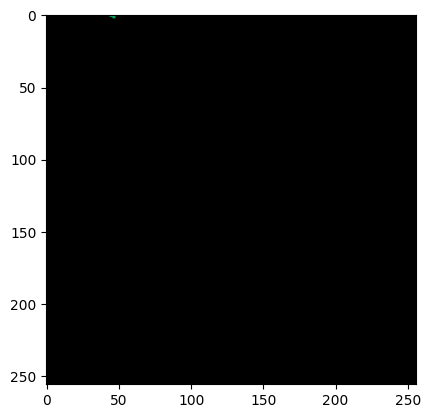

(256, 256, 3) (256, 256, 3)


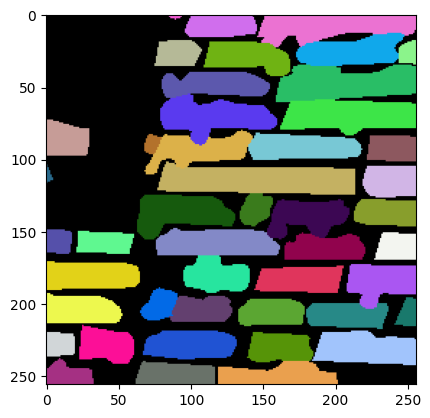

(256, 256, 3) (256, 256, 3)


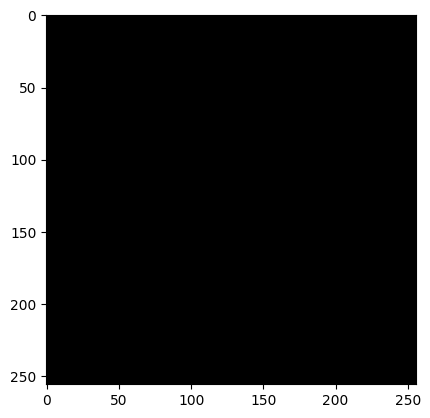

(256, 256, 3) (256, 256, 3)


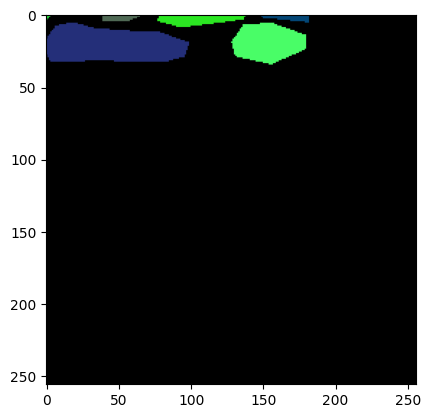

(256, 256, 3) (256, 256, 3)


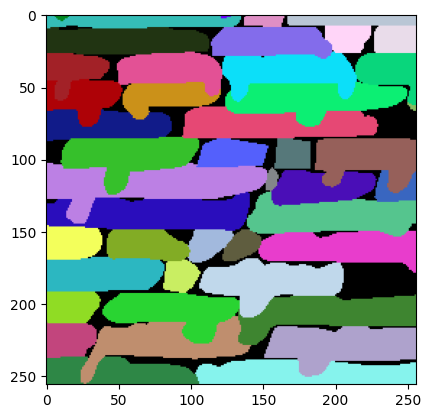

(256, 256, 3) (256, 256, 3)


In [45]:
batch = next(iter(val_loader))

In [46]:
def show_random_predict(model, loader, batch=None, threshold = 0.5):
  model.eval()
  if batch is None:
    batch = next(iter(loader))
  img = batch[0][0]

  prediction = model([img.to(device)])
  masks = prediction[0]['masks']
  masks = masks[prediction[0]['scores'] > 0.5]
  model.train()

  img = torch.moveaxis(img, 0, -1).cpu()
  img = (np.array(img) * 255).astype(np.uint8)
  res = np.zeros_like(img).astype(np.uint8)

  masks = [el.squeeze().detach().cpu().numpy() > threshold for el in masks]
  masks = sorted(masks, key=lambda x: x.sum())
  for mask in masks:
    res[mask] = np.random.randint(0, 255, size=(3))

  plt.figure(figsize=(10, 20))
  plt.imshow(np.concatenate([img, res], axis=1))
  plt.show()

# Train with guide

In [47]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_instance_segmentation_model(num_classes = 2):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [48]:
import utils
import engine

In [49]:
import importlib
importlib.reload(engine)

<module 'engine' from '/content/engine.py'>

In [50]:
model = get_instance_segmentation_model(2)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=3e-4)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=15,
                                                gamma=0.1)


(256, 256, 3) (256, 256, 3)
(256, 256, 3) (256, 256, 3)
(256, 256, 3) (256, 256, 3)


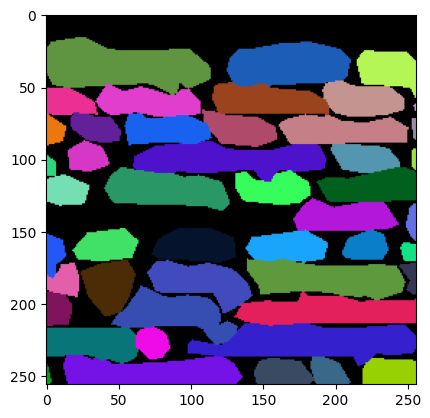

(256, 256, 3) (256, 256, 3)


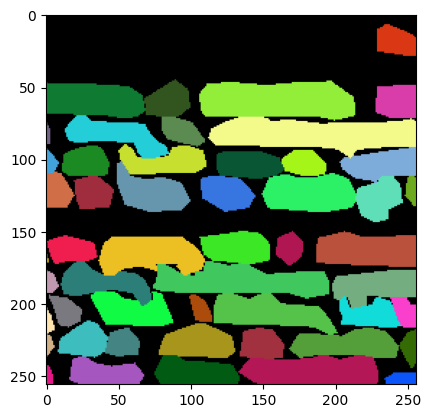

(256, 256, 3) (256, 256, 3)


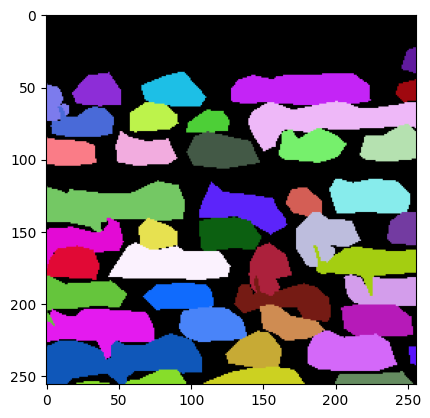

(256, 256, 3) (256, 256, 3)


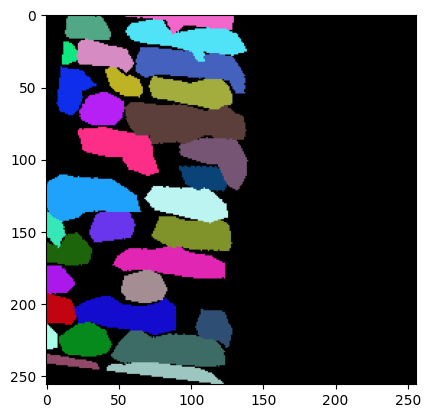

(256, 256, 3) (256, 256, 3)


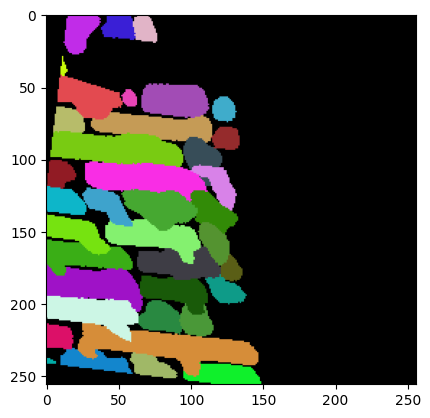

(256, 256, 3) (256, 256, 3)


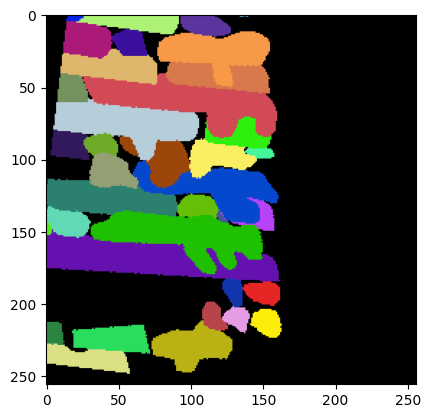

(256, 256, 3) (256, 256, 3)


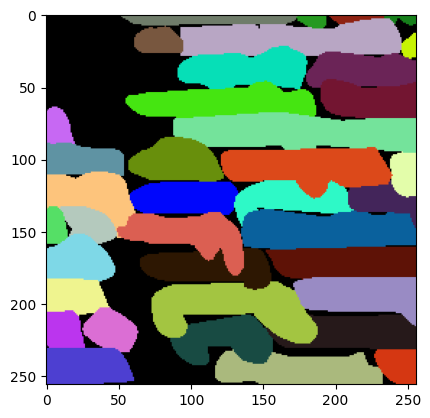

(256, 256, 3) (256, 256, 3)


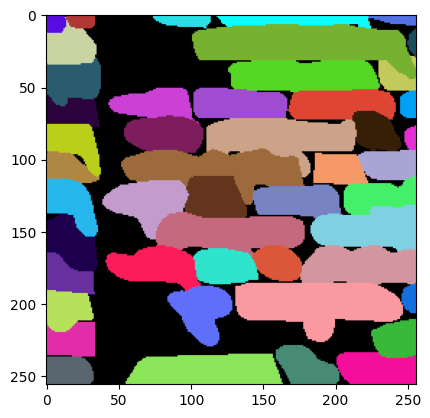

(256, 256, 3) (256, 256, 3)


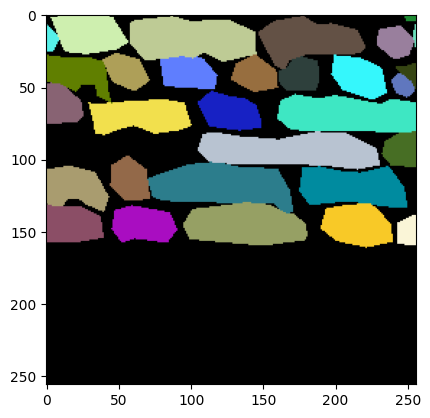

(256, 256, 3) (256, 256, 3)


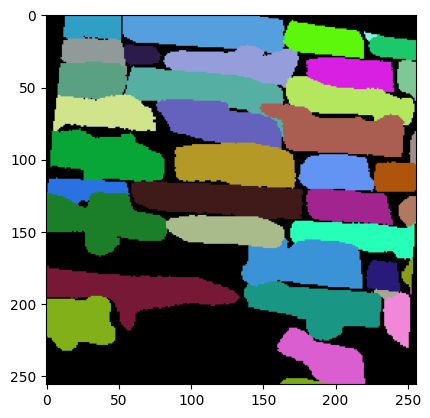

(256, 256, 3) (256, 256, 3)


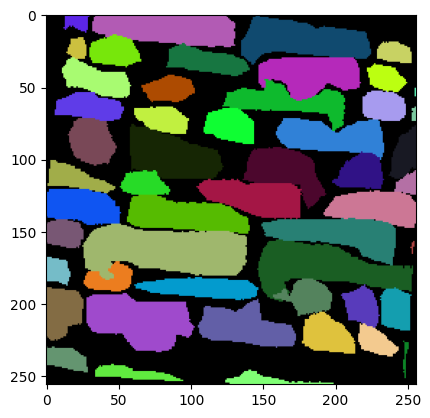

(256, 256, 3) (256, 256, 3)


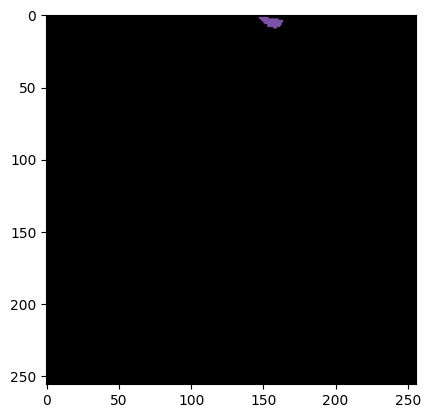

(256, 256, 3) (256, 256, 3)


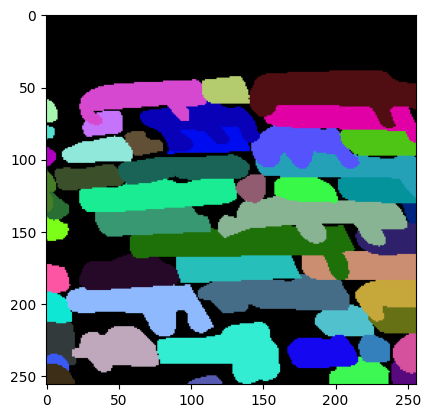

(256, 256, 3) (256, 256, 3)


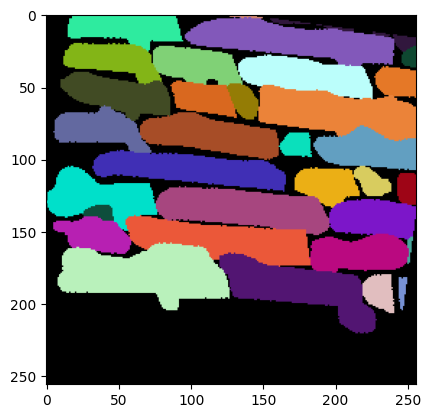

(256, 256, 3) (256, 256, 3)


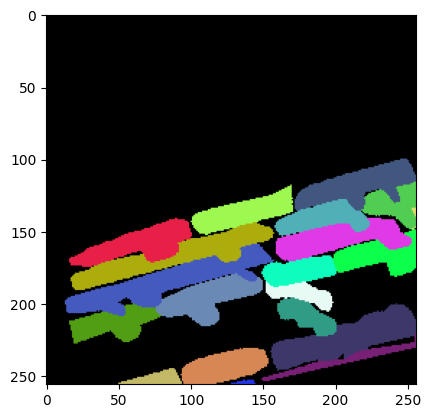

(256, 256, 3) (256, 256, 3)


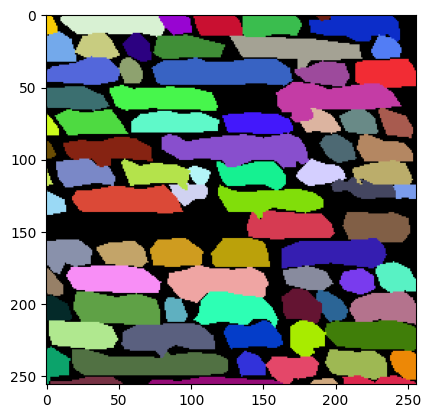

(256, 256, 3) (256, 256, 3)
Epoch: [0]  [0/3]  eta: 0:07:16  lr: 0.000150  loss: 10.3797 (10.3797)  loss_classifier: 1.0359 (1.0359)  loss_box_reg: 0.5574 (0.5574)  loss_mask: 4.2237 (4.2237)  loss_objectness: 4.1722 (4.1722)  loss_rpn_box_reg: 0.3906 (0.3906)  time: 145.5632  data: 142.8640  max mem: 7211


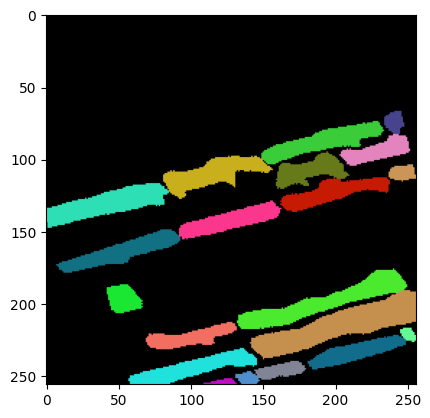

(256, 256, 3) (256, 256, 3)
Epoch: [0]  [2/3]  eta: 0:00:55  lr: 0.000300  loss: 10.3797 (8.1941)  loss_classifier: 0.9947 (0.8749)  loss_box_reg: 0.7118 (0.7253)  loss_mask: 4.2007 (3.1169)  loss_objectness: 4.1722 (3.1241)  loss_rpn_box_reg: 0.3621 (0.3529)  time: 55.5461  data: 53.6610  max mem: 7603
Epoch: [0] Total time: 0:02:46 (55.6216 s / it)


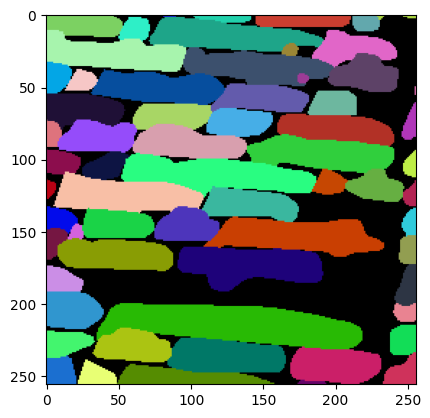

(256, 256, 3) (256, 256, 3)


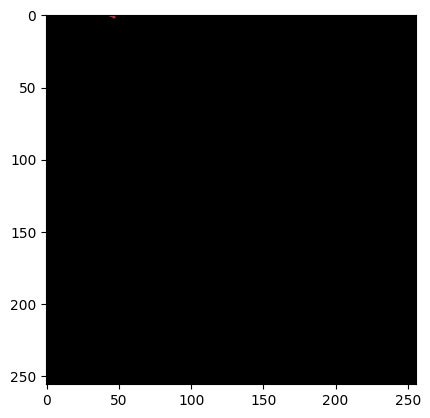

(256, 256, 3) (256, 256, 3)


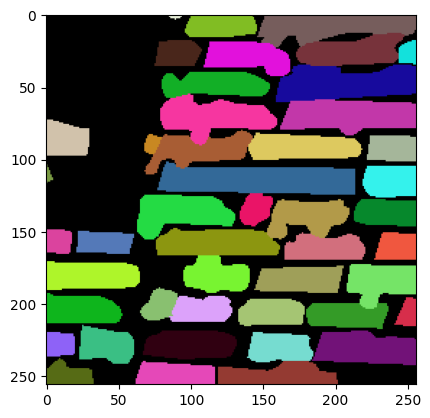

(256, 256, 3) (256, 256, 3)


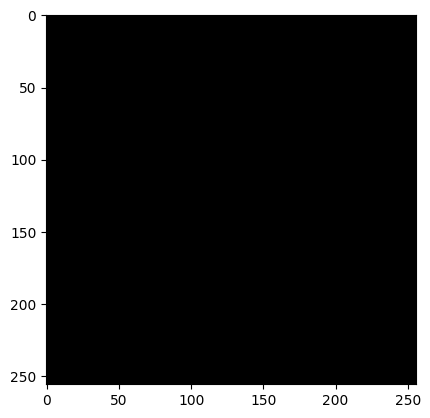

(256, 256, 3) (256, 256, 3)


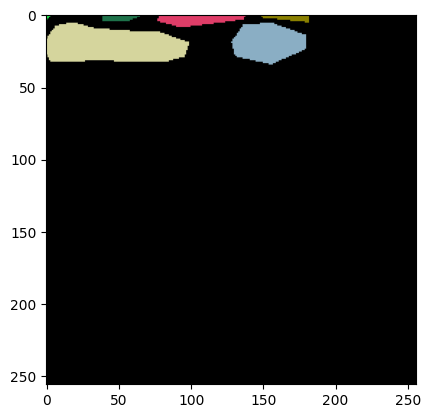

(256, 256, 3) (256, 256, 3)


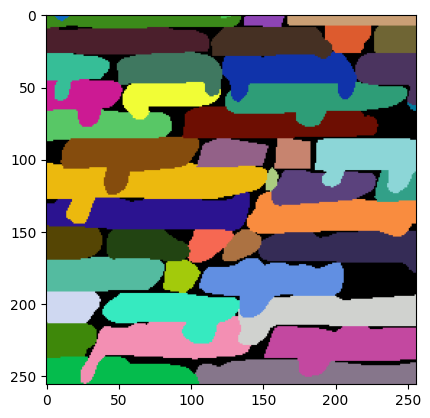

(256, 256, 3) (256, 256, 3)
creating index...
index created!
(256, 256, 3) (256, 256, 3)


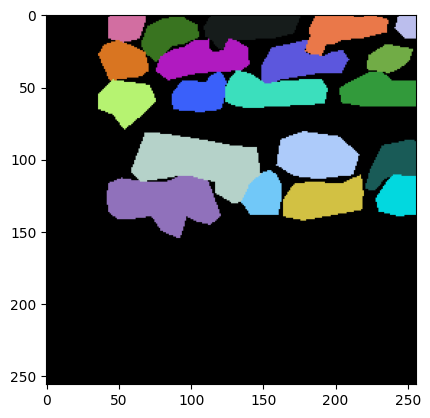

(256, 256, 3) (256, 256, 3)


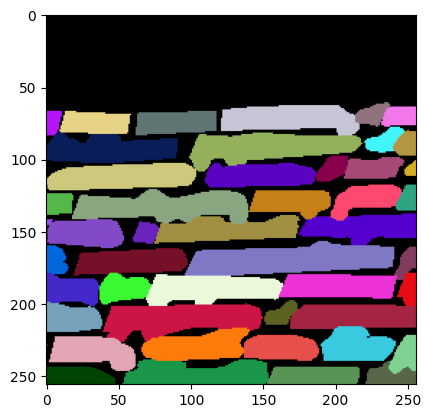

(256, 256, 3) (256, 256, 3)


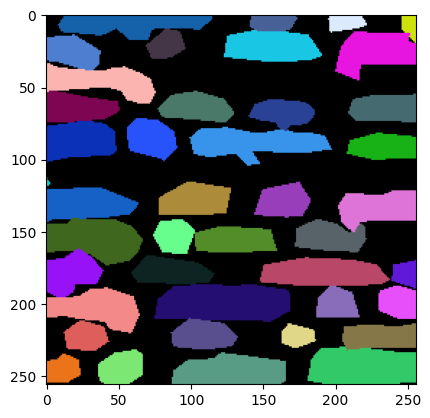

(256, 256, 3) (256, 256, 3)


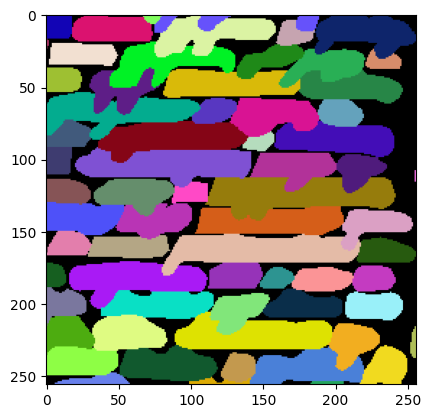

(256, 256, 3) (256, 256, 3)
Test:  [0/1]  eta: 0:00:53  model_time: 0.9208 (0.9208)  evaluator_time: 0.6251 (0.6251)  time: 53.2126  data: 51.6577  max mem: 7603
Test: Total time: 0:00:53 (53.4143 s / it)
Averaged stats: model_time: 0.9208 (0.9208)  evaluator_time: 0.6251 (0.6251)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0

TypeError: '<' not supported between instances of 'NoneType' and 'float'

In [51]:
# let's train it for 10 epochs
num_epochs = 10
eval_freq = 10
best_loss = 1e9

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    now_loss = engine.train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=200)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    if epoch % eval_freq == 0:
      engine.evaluate(model, val_loader, device=device)

    if now_loss < best_loss:
      best_loss = now_loss
      print('updating best model, now it {}'.format(best_loss))
      torch.save(model, '/content/drive/MyDrive/mask_rcnn_models/mask_rcnn_small_adam_en_best')

    torch.save(model, '/content/drive/MyDrive/mask_rcnn_models/mask_rcnn_small_adam_en_last')
    show_random_predict(model, val_loader, batch)

# Train myself

## Train loops

In [ ]:
warmup_scheduler = None

In [ ]:
def train_epoch(model, batch_gen, criterion, optimizer, is_train = True) :
    loss_sum = collections.defaultdict(int)
    count = 0
    loss_names = ['loss_box_reg', 'loss_rpn_box_reg', 'loss_objectness', 'loss_classifier', 'loss_mask'] #
    # model.train(is_train)

    for images, targets in tqdm(batch_gen):
        # print(input.shape, labels)
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.set_grad_enabled(is_train):
            loss_dict = model(images, targets)
            losses = sum(loss_dict[k] for k in loss_names)

            for k in loss_names:
              loss_sum[k] += loss_dict[k].item()

            loss_sum['loss'] += losses.item()

            if is_train :
                optimizer.zero_grad()
                losses.backward()
                optimizer.step()

            count += len(images)

        if warmup_scheduler is not None:
          warmup_scheduler.step()

    return {k: v / count for k,v in loss_sum.items()}

In [ ]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, save_name, verbose=True):
    loader = {'train': train_loader, 'test': test_loader}
    loss_history = {'train': [], 'test': []}
    best_loss = 10

    warmup_factor = 1. / 1000
    warmup_iters = min(1000, len(train_loader) - 1)
    warmup_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for epoch in range(num_epochs):
        if verbose:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        for phase in ['train', 'test']:
            epoch_loss = train_epoch(model, loader[phase], criterion, optimizer, phase == 'train')
            warmup_scheduler = None

            if verbose:
                print('{} Loss: {} '.format(phase, epoch_loss))
            loss_history[phase].append(epoch_loss)

        scheduler.step()

        if best_loss > loss_history['test'][-1]['loss']:
          best_loss = loss_history['test'][-1]['loss']
          torch.save(model, '/content/drive/MyDrive/segmentation_models/{}_best'.format(save_name))
          print('updated best loss, now it {}'.format(best_loss))

        torch.save(model, '/content/drive/MyDrive/segmentation_models//{}_last'.format(save_name))
        if verbose:
            show_random_predict(model, test_loader, batch)
            print()

    return loss_history

## Train mask-rcnn

In [ ]:
model = get_instance_segmentation_model()
model = model.to(device)


params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=3e-4)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=20,
                                               gamma=0.5)

In [ ]:
history = train_model(model, train_loader, val_loader, None, optimizer, lr_scheduler, 30, 'mask_rcnn_small_2')

In [ ]:
train_epoch(model, val_loader, None, optimizer, False) #small

In [ ]:
np.random.seed(42)
train_epoch(model, val_loader, None, optimizer, False) #small_2

In [ ]:
np.random.seed(42)
train_epoch(model, val_loader, None, optimizer, False) #small_2_best